<a href="https://colab.research.google.com/github/shu65/diffusion-model-book/blob/main/diffusion_model_book_3_VE_SDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tqdm import tqdm_notebook as tqdm
import torch

device="cpu"

In [ ]:
n_samples = int(1e6)
sigma = 0.01

dist0 = torch.distributions.MultivariateNormal(torch.tensor([-2, -2], dtype=torch.float).to(device), sigma*torch.eye(2, dtype=torch.float).to(device))
samples0 = dist0.sample(torch.Size([n_samples//2]))
    
dist1 = torch.distributions.MultivariateNormal(torch.tensor([2, 2], dtype=torch.float).to(device), sigma*torch.eye(2, dtype=torch.float).to(device))
samples1 = dist1.sample(torch.Size([n_samples//2]))
samples = torch.vstack((samples0, samples1))

mean = torch.mean(samples, dim=0)
std = torch.std(samples, dim=0)

normalized_samples = (samples - mean[None, :])/std[None, :]

dataset = torch.utils.data.TensorDataset((normalized_samples))

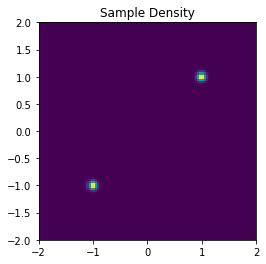

In [ ]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

plot_samples = normalized_samples.cpu().numpy()

plt.hist2d(plot_samples[:,0], plot_samples[:,1], range=((-2, 2), (-2, 2)), cmap='viridis', rasterized=False, bins=100, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.title('Sample Density')
plt.show()

In [ ]:
sigma_min = torch.tensor(0.01, device=device)
sigma_max = torch.tensor(10.0, device=device) 

def sigma(t, sigma_min=sigma_min, sigma_max=sigma_max):
  return sigma_min * (sigma_max / sigma_min) ** t 

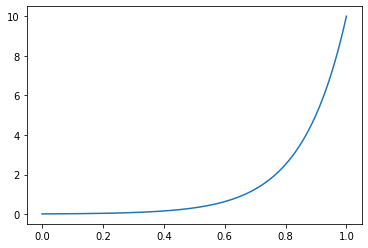

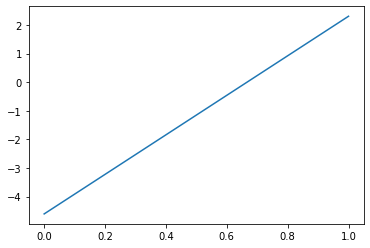

In [ ]:
plot_t = torch.linspace(0, 1, 1000, device=device)
plot_log_sigma = sigma(plot_t)

plt.plot(plot_t.cpu().numpy(), plot_log_sigma.cpu().numpy())
plt.show()
plt.plot(plot_t.cpu().numpy(), np.log(plot_log_sigma.cpu().numpy()))
plt.show()

In [ ]:
def ve_sde_marginal_prob_statistics(x, t, sigma_min, sigma_max):
  mean = x
  std = sigma(t=t, sigma_min=sigma_min, sigma_max=sigma_max)
  return mean, std

In [ ]:
def ve_sde_drift(t, sigma_min, sigma_max):
  drift = torch.zeros_like(t)
  return drift

def ve_sde_diffusion(t, sigma_min, sigma_max):
  std = sigma(t=t, sigma_min=sigma_min, sigma_max=sigma_max)
  diffusion = std * torch.sqrt(2 * (torch.log(sigma_max) - torch.log(sigma_min))) # (30)
  return diffusion

In [ ]:
def dsm_loss(score_model, samples, sigma_min, sigma_max):
  eps = 1.0e-8
  t = torch.distributions.uniform.Uniform(torch.tensor([eps], device=samples.device), torch.tensor([1], device=samples.device)).sample([samples.shape[0]]) 
  z = torch.randn_like(samples)
  mean, std = ve_sde_marginal_prob_statistics(x=samples, t=t, sigma_min=sigma_min, sigma_max=sigma_max)
  noise = z * std
  perturbed_samples = mean + z * std
  scores = score_model(perturbed_samples, t)
  target = - 1 / (std ** 2) * noise
  
  target = target.view(target.shape[0], -1)
  scores = scores.view(scores.shape[0], -1)
  g = ve_sde_diffusion(t=t, sigma_min=sigma_min, sigma_max=sigma_max)
  lmd = g ** 2
  loss = torch.sqrt(((scores - target) ** 2).sum(dim=-1)) * lmd
  return loss.mean()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class ScoreModel(nn.Module):
  def __init__(self, sigma_min, sigma_max, n_channels=2):
    super(ScoreModel, self).__init__()
    self.sigma_min = sigma_min
    self.sigma_max = sigma_max
    self.model = nn.Sequential(
        nn.Linear(n_channels, 2*n_channels),
        nn.ELU(),
        nn.Linear(2*n_channels, 16*n_channels),
        nn.ELU(),
        nn.Linear(16*n_channels, 2*n_channels),
        nn.ELU(),
        nn.Linear(2*n_channels, n_channels),
    )

  def forward(self, x, t):
    y = self.model(x)
    sigma_t = sigma(t=t, sigma_min=self.sigma_min, sigma_max=self.sigma_max)
    return y/sigma_t

In [ ]:
import torch

batch_size = 512
n_steps = 100000

dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True, num_workers=0)
dataloader_iter = iter(dataloader)

score_model = ScoreModel(sigma_min=sigma_min, sigma_max=sigma_max).to(device)

optimizer = torch.optim.Adam(score_model.parameters())
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=n_steps)

for i in range(n_steps):
  try:
    x = next(dataloader_iter)[0]
  except StopIteration:
    dataloader_iter = iter(dataloader)
    x = next(dataloader_iter)[0]
  x = x.to(device)

  optimizer.zero_grad()
  loss = dsm_loss(score_model, x, sigma_min=sigma_min, sigma_max=sigma_max)
  loss.backward()
  optimizer.step()
  lr_scheduler.step()
  if (i % 1000) == 0:
    print(f"{i} steps loss:{loss}")

0 steps loss:1859.2049560546875
1000 steps loss:1944.5516357421875
2000 steps loss:2025.0797119140625
3000 steps loss:1731.193359375
4000 steps loss:1460.9530029296875
5000 steps loss:1305.2705078125
6000 steps loss:1971.225341796875
7000 steps loss:1768.1434326171875
8000 steps loss:1572.624755859375
9000 steps loss:1639.954345703125
10000 steps loss:1911.223876953125
11000 steps loss:1662.96435546875
12000 steps loss:1700.100341796875
13000 steps loss:1971.902587890625
14000 steps loss:1711.3748779296875
15000 steps loss:1776.391845703125
16000 steps loss:1484.6676025390625
17000 steps loss:1919.545654296875
18000 steps loss:1619.9324951171875
19000 steps loss:1688.3319091796875
20000 steps loss:1337.708740234375
21000 steps loss:1704.1593017578125
22000 steps loss:1349.9967041015625
23000 steps loss:1664.606201171875
24000 steps loss:1819.019287109375
25000 steps loss:1611.3419189453125
26000 steps loss:1434.19580078125
27000 steps loss:1729.96923828125
28000 steps loss:1770.2747802

In [ ]:
def euler_maruyama_sample(n_samples, score_model, device=device, n=1000):
  with torch.no_grad():
    x = torch.randn(n_samples, 2, device=device)
    dt = torch.tensor(1.0 / n, device=x.device)
    for t in range(n, 0, -1):
      if (t % 10) == 0:
        print(f"t:{t}")
      assert not torch.any(torch.isnan(x))
      t_tensor = torch.full((n_samples, 1), t/n, device=device)
      z = torch.randn(n_samples, 2)
      f = ve_sde_drift(t_tensor, score_model.sigma_min, score_model.sigma_max)
      g = ve_sde_diffusion(t_tensor, score_model.sigma_min, score_model.sigma_max)
      g2 = g ** 2
      score = score_model(x, t_tensor)
      x = x - (f*x - g2 * score) * dt + g * torch.sqrt(dt) * z
    return x

In [ ]:
samples_pred = euler_maruyama_sample(n_samples=100000, score_model=score_model)
samples_pred = samples_pred.cpu().numpy()

t:1000
t:990
t:980
t:970
t:960
t:950
t:940
t:930
t:920
t:910
t:900
t:890
t:880
t:870
t:860
t:850
t:840
t:830
t:820
t:810
t:800
t:790
t:780
t:770
t:760
t:750
t:740
t:730
t:720
t:710
t:700
t:690
t:680
t:670
t:660
t:650
t:640
t:630
t:620
t:610
t:600
t:590
t:580
t:570
t:560
t:550
t:540
t:530
t:520
t:510
t:500
t:490
t:480
t:470
t:460
t:450
t:440
t:430
t:420
t:410
t:400
t:390
t:380
t:370
t:360
t:350
t:340
t:330
t:320
t:310
t:300
t:290
t:280
t:270
t:260
t:250
t:240
t:230
t:220
t:210
t:200
t:190
t:180
t:170
t:160
t:150
t:140
t:130
t:120
t:110
t:100
t:90
t:80
t:70
t:60
t:50
t:40
t:30
t:20
t:10


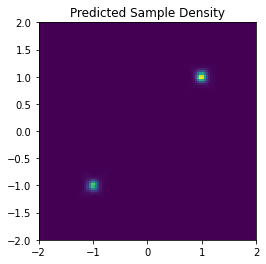

In [ ]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

plt.hist2d(samples_pred[:,0], samples_pred[:,1], range=((-2, 2), (-2, 2)), cmap='viridis', rasterized=False, bins=100, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.title('Predicted Sample Density')
plt.show()